_Author: A. Spiga_

In [2]:
import apss_lib
apss_lib.verbose = False
import wavelet
import ppcompute
import numpy as np
import ppplot
import scipy.interpolate as spint
%matplotlib inline

2019-12-09 23:30:04.617496


In [3]:
soltab = [140,142,150] 
mint = 1 ; maxt = 5
win1 = 100 ; win2 = 3700.

/home/aspiga/soft/planetoplot/modules/ppplot.py:296: RuntimeWarning: invalid value encountered in less
  else:          what_I_plot[ what_I_plot < zevmin*(1.+small_enough) ] = zevmin*(1.+small_enough)
/home/aspiga/soft/planetoplot/modules/ppplot.py:297: RuntimeWarning: invalid value encountered in greater
  what_I_plot[ what_I_plot > miss  ] = -miss
/home/aspiga/soft/planetoplot/modules/ppplot.py:298: RuntimeWarning: invalid value encountered in greater
  what_I_plot[ what_I_plot > zevmax ] = zevmax*(1.-small_enough)


---- SOL 140 ----
estimate wave-induced p' = 0.4
estimate wave-induced V' = 1.2
non-linear effect negligible if ratio << 1: ratio = 0.03
horizontal wavelength 31 km
phase speed 21 m/s
---- SOL 142 ----
estimate wave-induced p' = 0.4
estimate wave-induced V' = 1.5
non-linear effect negligible if ratio << 1: ratio = 0.06
horizontal wavelength 25 km
phase speed 17 m/s


/home/aspiga/soft/conda/miniconda2/envs/py2/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


---- SOL 150 ----
estimate wave-induced p' = 0.3
estimate wave-induced V' = 0.9
non-linear effect negligible if ratio << 1: ratio = 0.02
horizontal wavelength 33 km
phase speed 22 m/s


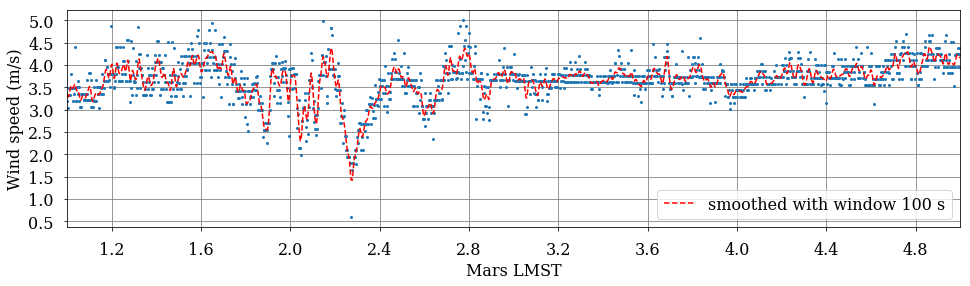

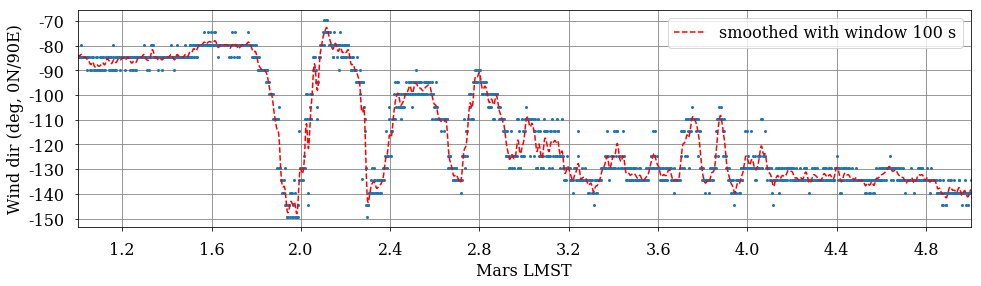

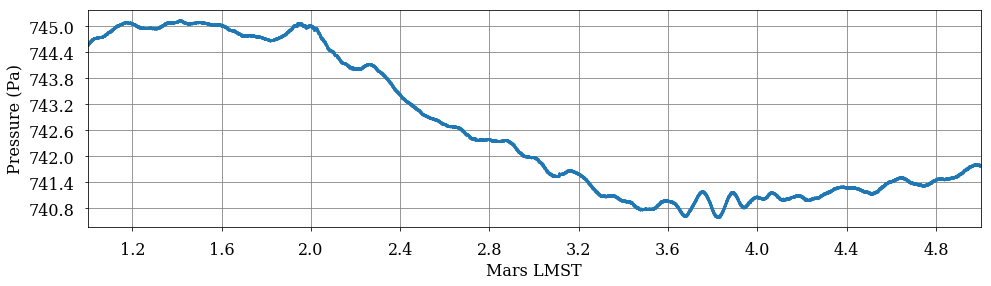

<Figure size 1152x288 with 0 Axes>

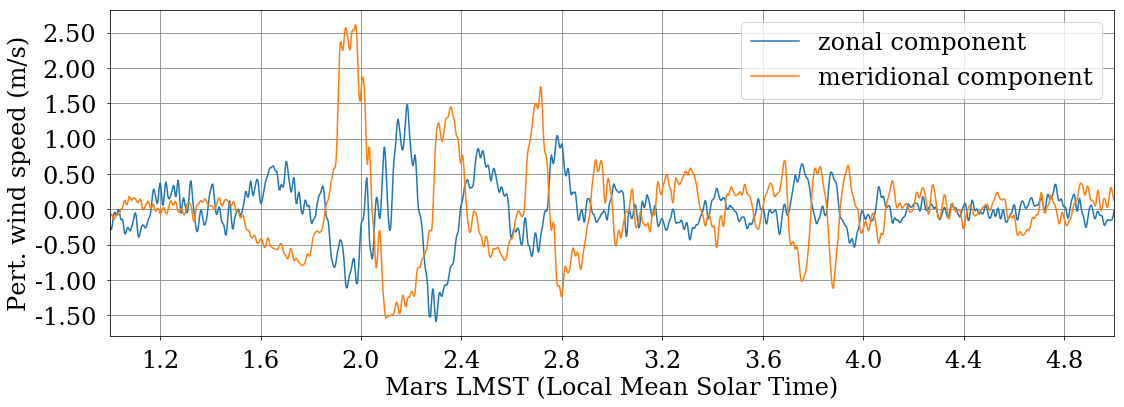

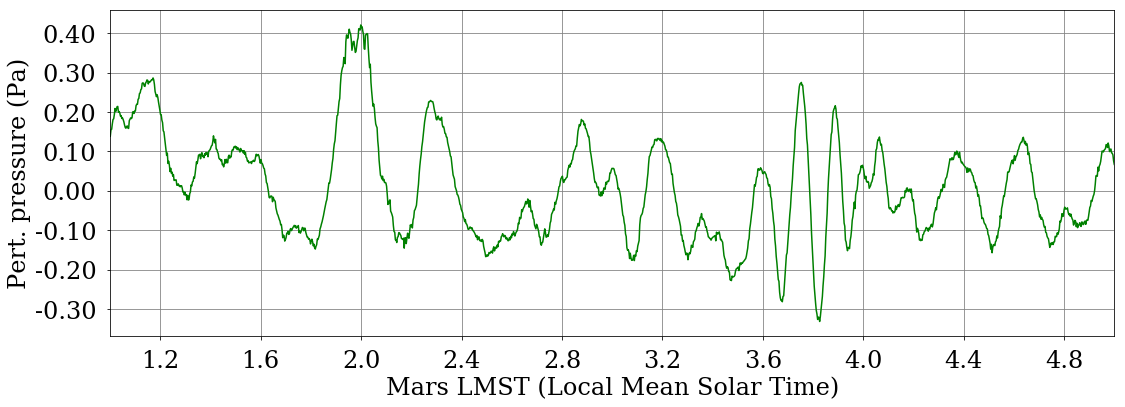

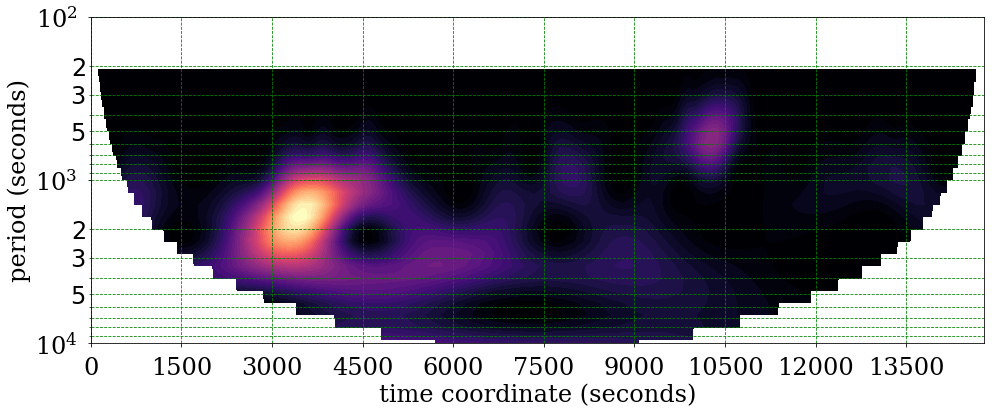

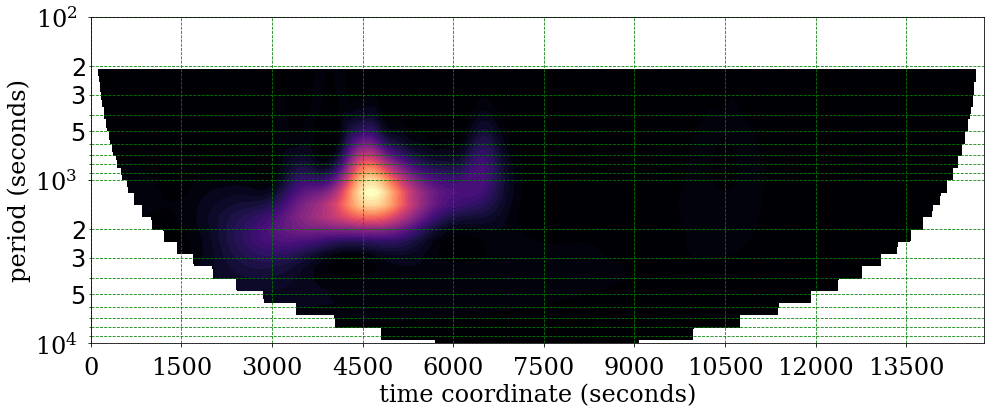

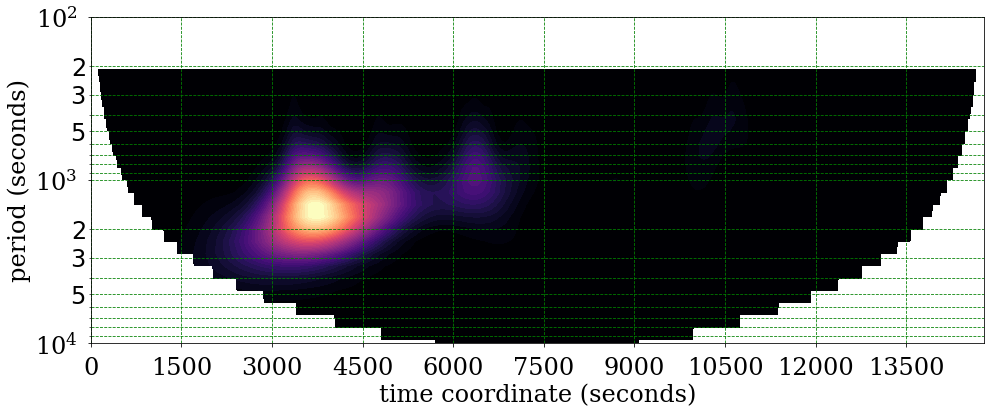

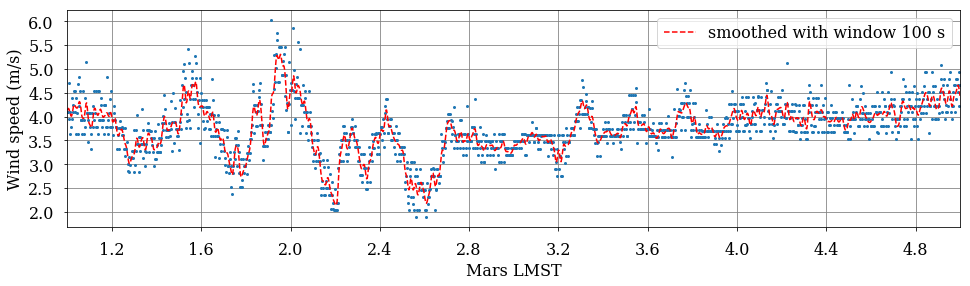

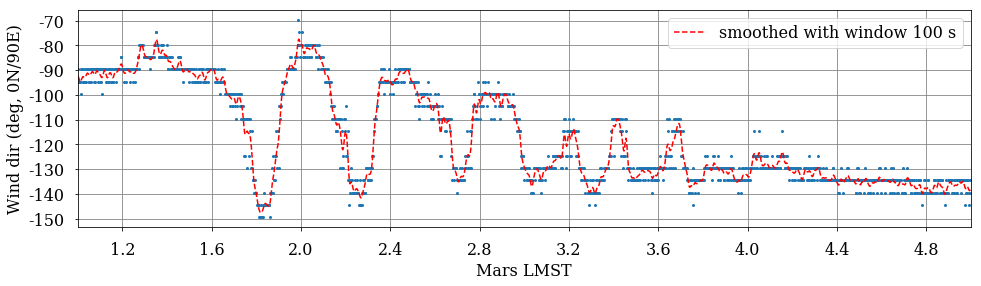

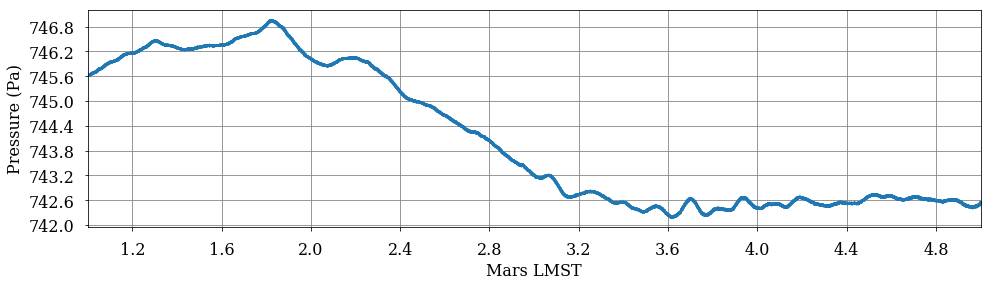

<Figure size 1152x288 with 0 Axes>

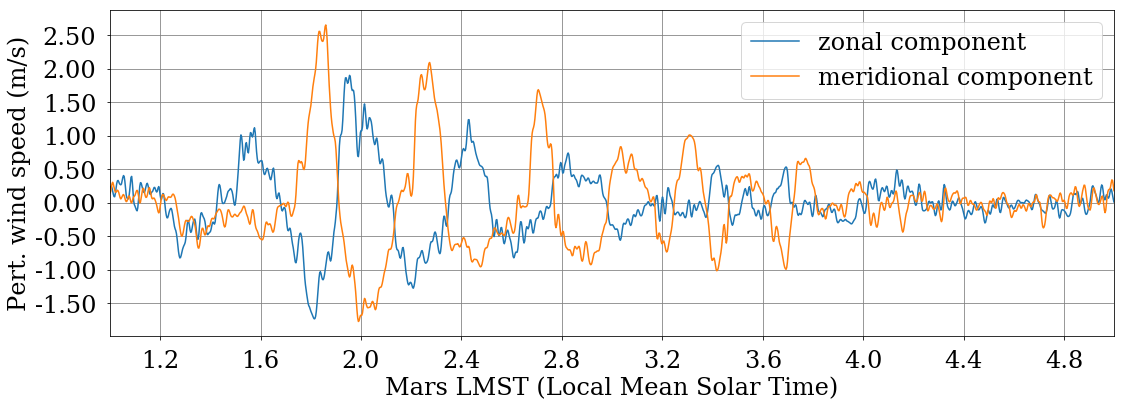

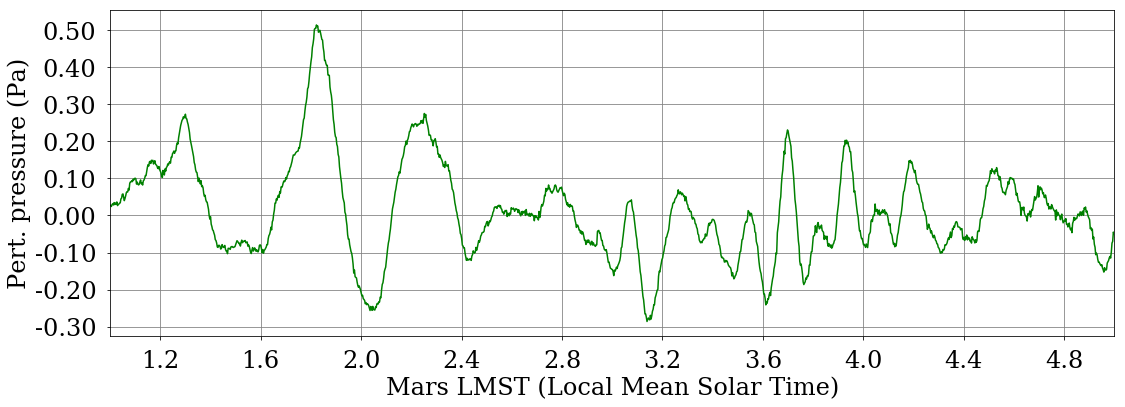

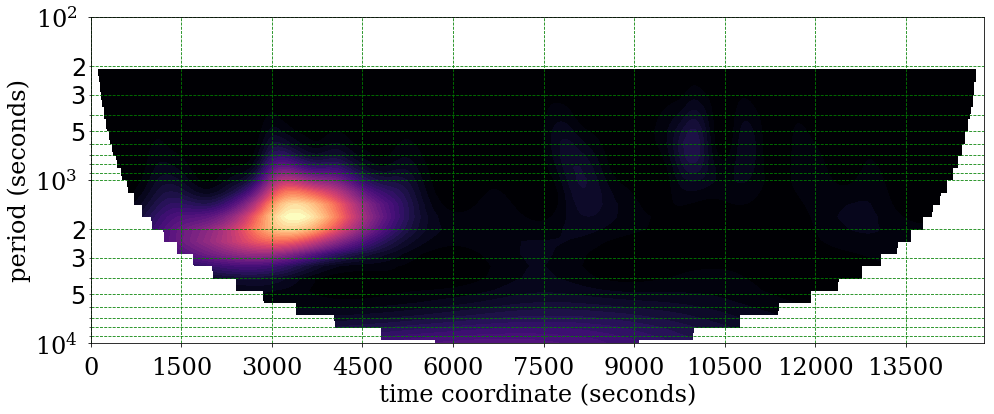

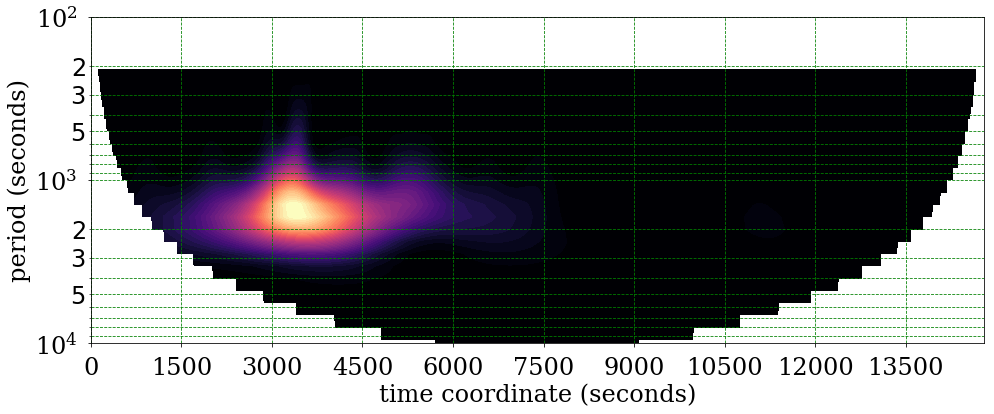

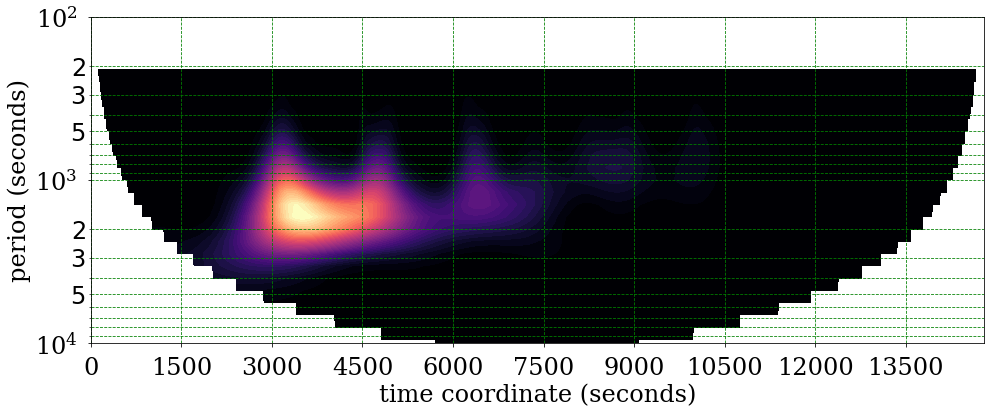

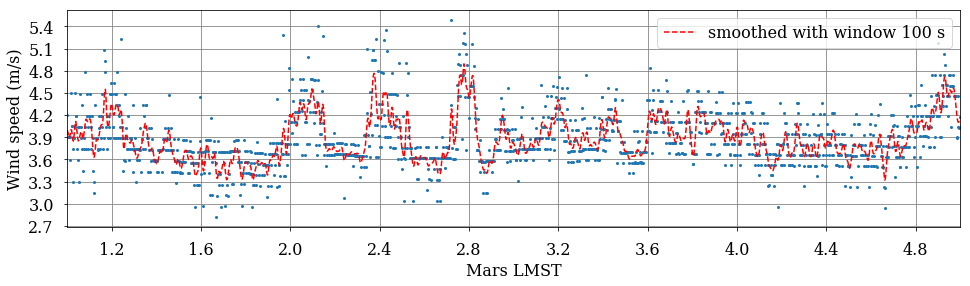

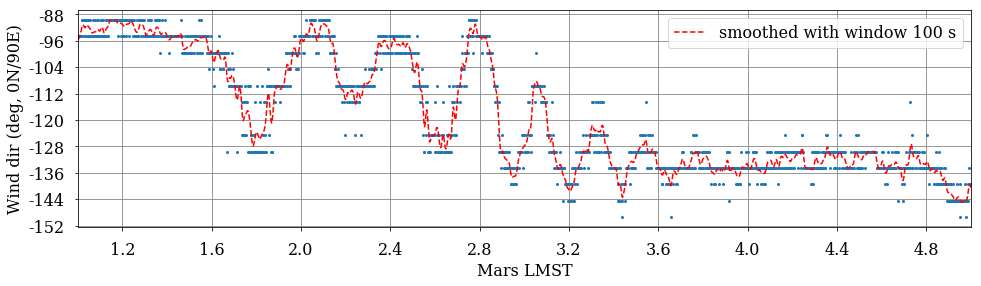

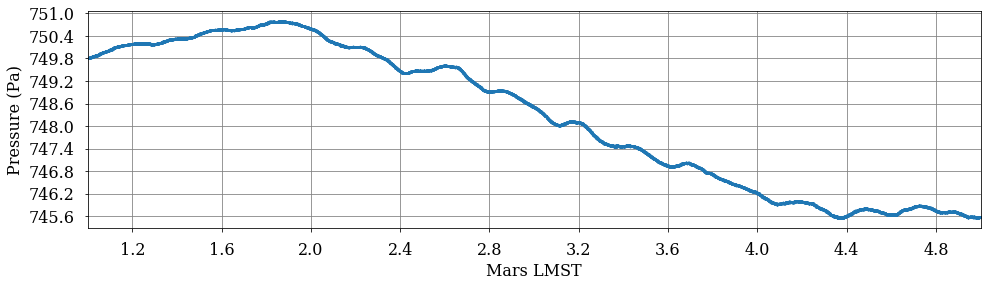

<Figure size 1152x288 with 0 Axes>

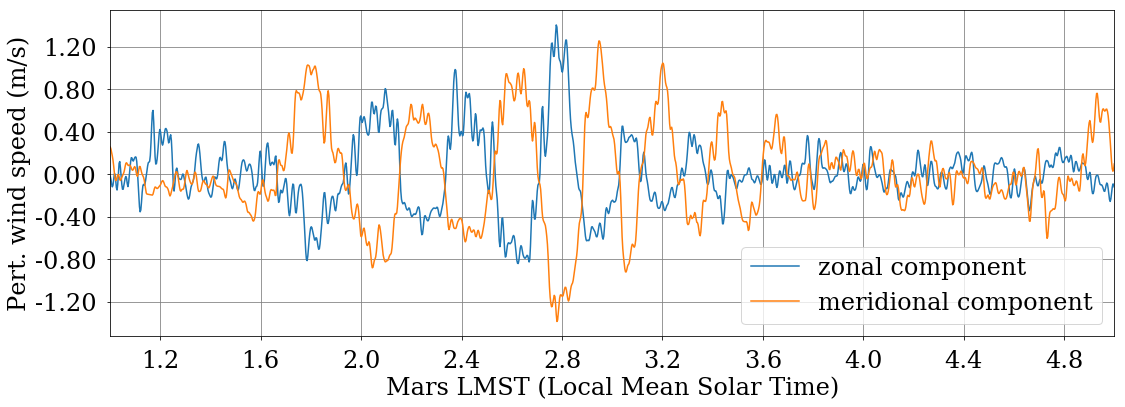

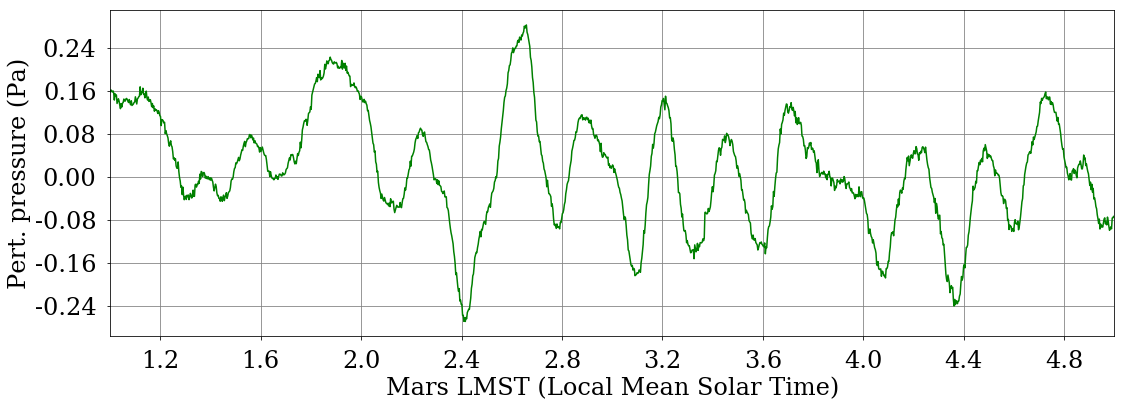

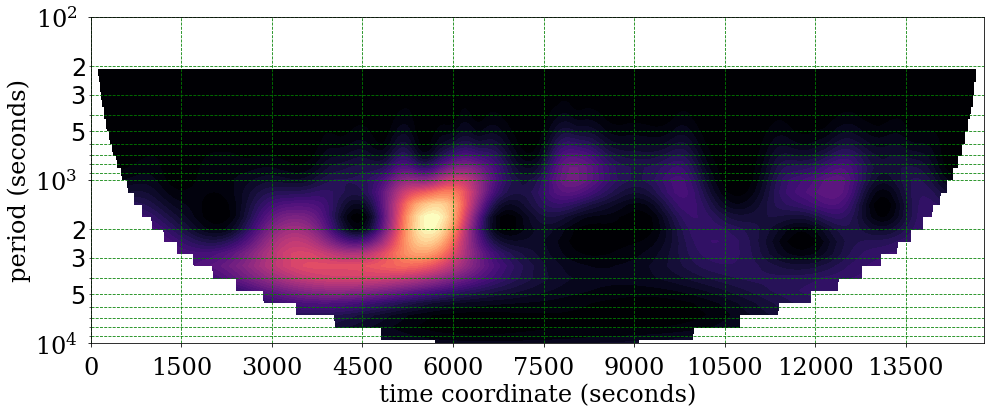

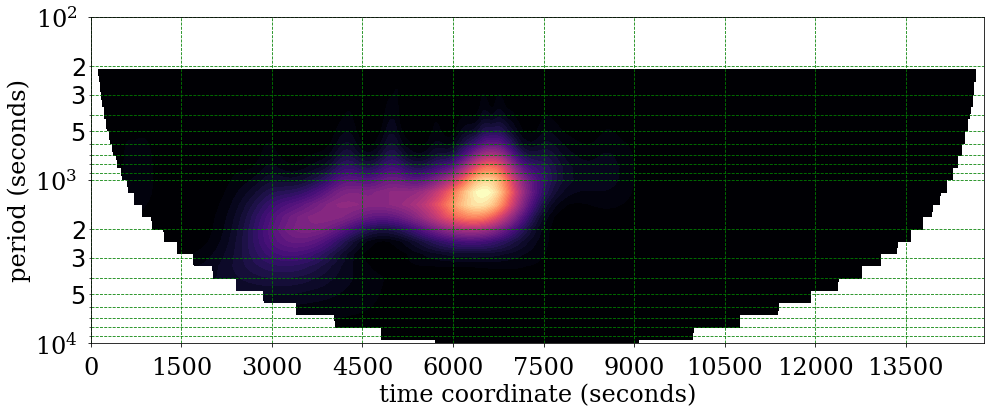

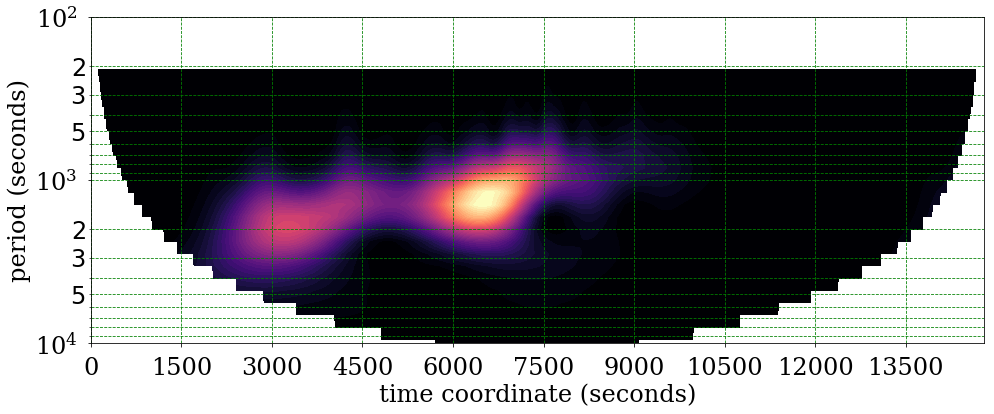

In [4]:
for sol in soltab:
    filename = "gw_%i" % (sol)
    #### load data wind and pressure
    data = apss_lib.getsol(sol,var="PRE",distant=True) ; freq = ppcompute.max(data["PRESSURE_FREQUENCY"])
    dataw = apss_lib.getsol(sol,var="HWS",distant=True) ; freqw = ppcompute.max(dataw["WIND_FREQUENCY"])
    #### perform low-pass filtering [win1 seconds] for (noisy) wind fields
    #### plot raw wind measurements and smoothed fields
    ws, ttw = apss_lib.plotvar(dataw,code=["HWS"],discrete="o",\
                               window=win1,freq=freqw,addsmooth=True,\
                               mint=mint,maxt=maxt,timetype="LMST",\
                               filename=filename)
    wd, ttw = apss_lib.plotvar(dataw,code=["WD"] ,discrete="o",\
                               window=win1,freq=freqw,addsmooth=True,\
                               mint=mint,maxt=maxt,timetype="LMST",\
                               filename=filename)
    #### calculate wind components
    u = -ws*np.sin(wd*np.pi/180.)
    v = -ws*np.cos(wd*np.pi/180.)
    #### perform high-pass filtering [win2 seconds] to detrend wind components
    u, su = apss_lib.detrendsmooth(u,win2*freqw)
    v, sv = apss_lib.detrendsmooth(v,win2*freqw)
    ambwind = np.mean(np.sqrt(su**2+sv**2)) ## min and max not too far
    #### plot raw pressure measurements
    foo, bar = apss_lib.plotvar(data,code=["PRE"],discrete=".",\
                                mint=mint,maxt=maxt,timetype="LMST",\
                                filename=filename)   
    #### perform high-pass filtering [win2 seconds] to detrend pressure
    #### NB: low-pass filtering is not necessary because pressure is less noisy than winds
    pr, ttp = apss_lib.plotvar(data,code=["PRE"] ,discrete="o",\
                               window=win2,freq=freq,\
                               mint=mint,maxt=maxt,timetype="LMST",\
                               isplot=False)
    #### reinterpolate pressure (subsample to wind component frequency)
    func = spint.interpolate.interp1d(ttp, pr, kind="linear", fill_value="extrapolate")
    prw = func(ttw)      
    #### plot two wind components on the same plot
    ppplot.changefont(24)
    fig = ppplot.figuref(x=18,y=6)
    pl = ppplot.plot1d(fig=fig)
    pl.xmin = mint ; pl.xmax = maxt
    pl.fmt = '%.2f' ; pl.marker = ""
    pl.xlabel = "Mars LMST (Local Mean Solar Time)"
    pl.ylabel = "Pert. wind speed (m/s)"
    pl.f = u ; pl.x = ttw ; pl.legend = "zonal component" ; pl.make()
    pl.f = v ; pl.legend = "meridional component" ; pl.make()  
    ppplot.save(filename=filename+"_pwind",mode="pdf")
    #### plot pressure on another plot with same settings as above
    fig = ppplot.figuref(x=18,y=6)
    pl = ppplot.plot1d(fig=fig)
    pl.xmin = mint ; pl.xmax = maxt
    pl.fmt = '%.2f' ; pl.marker = "" ; pl.color = "green"
    pl.xlabel = "Mars LMST (Local Mean Solar Time)"
    pl.ylabel = "Pert. pressure (Pa)"
    pl.f = prw ; pl.x = ttw ; pl.make()
    ppplot.save(filename=filename+"_ppres",mode="pdf")
    #### perform wavelet analysis on pressure & winds to determine periods
    wavelet.wavelet(prw,freq=freqw,ymin=win1,ymax=10000.,filename=filename+"_ppres")
    wavelet.wavelet(u,freq=freqw,ymin=win1,ymax=10000.,filename=filename+"_pwindu")
    wavelet.wavelet(v,freq=freqw,ymin=win1,ymax=10000.,filename=filename+"_pwindv")
    #### calculate horizontal wavelength 
    #### using the impedance relationship 
    #### à la Gossard and Munk 1954
    period = 1500. # this is about the period detected by wavelet analysis
    rho_0 = 0.02 # (see commented check below)
    pprime = np.std(prw)*3.
    Vprime = np.std(ws)*3.
    print "---- SOL %i ----" % (sol)
    print "estimate wave-induced p' = %.1f" % (pprime)
    print "estimate wave-induced V' = %.1f" % (Vprime)
    #### check that linear impedance relationship is OK
    #### --- A Nonlinear Impedance Relation for the Surface Winds in Pressure Disturbances
    #### --- Coleman and Knupp JAS 2010
    print "non-linear effect negligible if ratio << 1: ratio = %.2f" % (0.5*rho_0*(Vprime**2) / pprime)
    dalambda = (ambwind + (pprime/(rho_0*Vprime)))*period/1000.
    print "horizontal wavelength %.0f km" % (dalambda)
    print "phase speed %.0f m/s" % ((dalambda*1000.)/period)
    #####
    ##### this is to check that rho_0 ~ 0.02 (correct)
    #datalim = apss_lib.reduced_data(dataw,mint=mint,maxt=maxt,timetype="LMST")    
    #mat = datalim["MAT"] ; pat = datalim["PAT"]
    #meant = 0.5*(ppcompute.mean(mat)+ppcompute.mean(mat))
    #datalim = apss_lib.reduced_data(data,mint=mint,maxt=maxt,timetype="LMST") 
    #meanp = ppcompute.mean(datalim["PRE"])
    #rho_0 = meanp / (192.*meant)
    #print rho_0

In [4]:
## on sol 140 there might be a second detected wave of smaller period 
period = 600.
pprime = 0.3
Vprime = 1.
ambwind = 3.5
dalambda = (ambwind+(pprime/(rho_0*Vprime)))*period/1000.
print "sol %i => horizontal wavelength %.0f km" % (140,dalambda)

sol 140 => horizontal wavelength 11 km


### Exploratory search of interesting sols

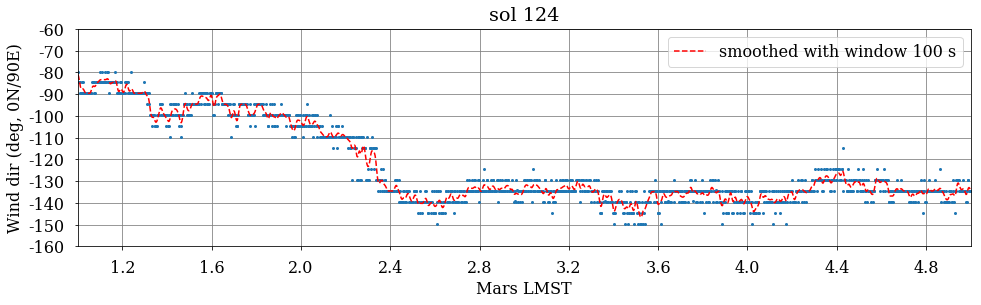

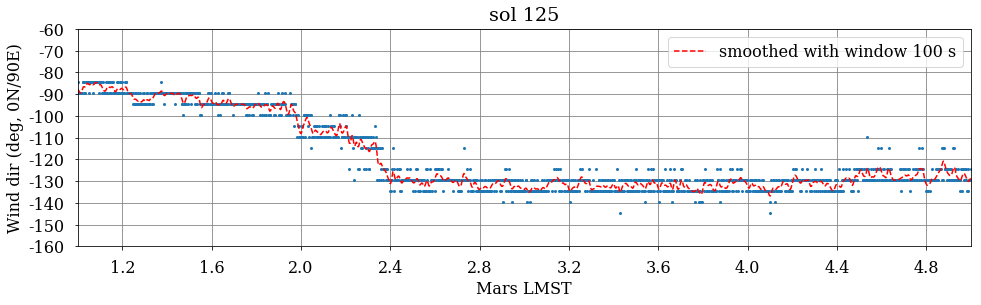

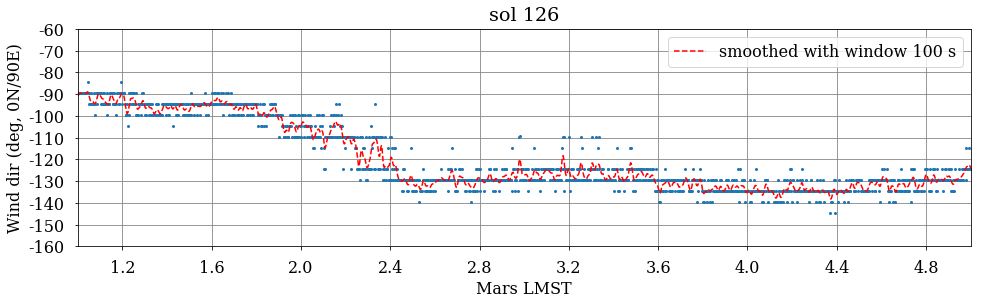

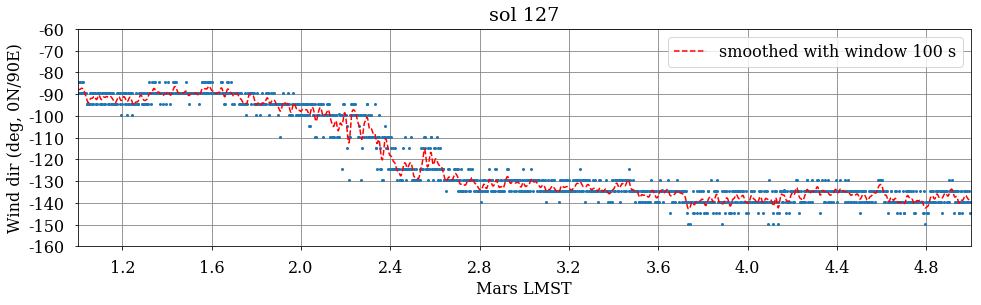

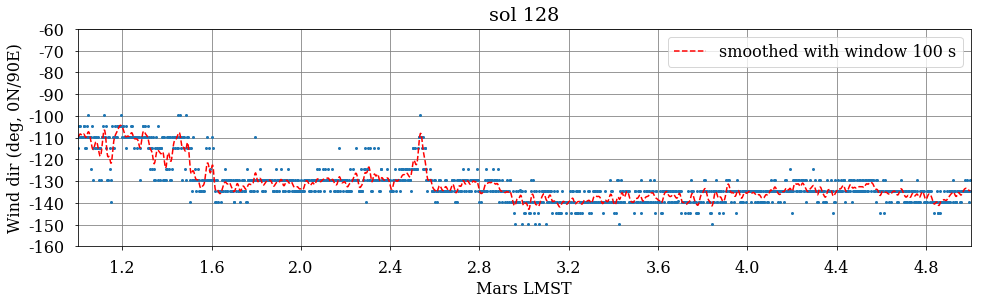

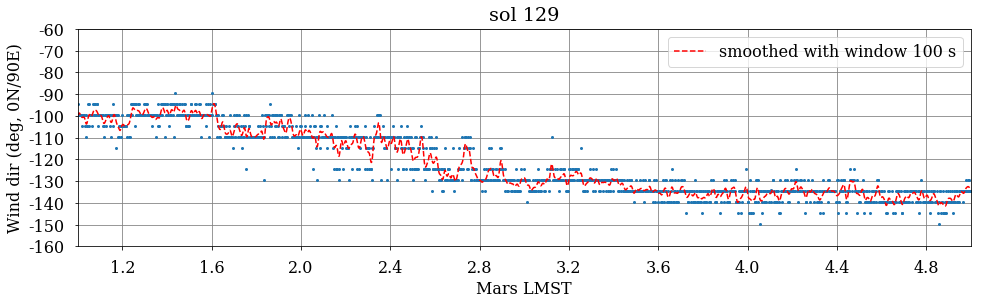

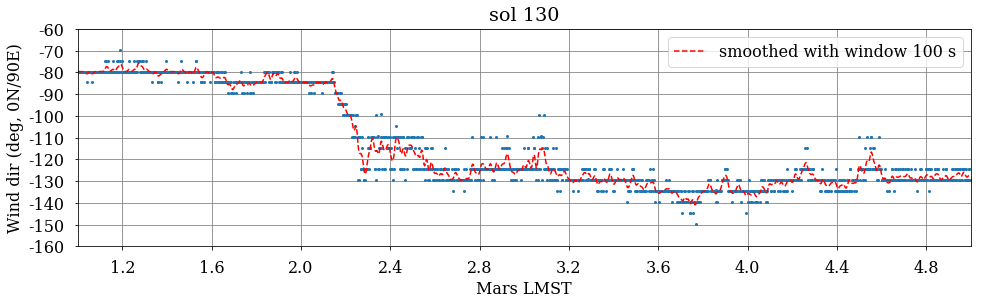

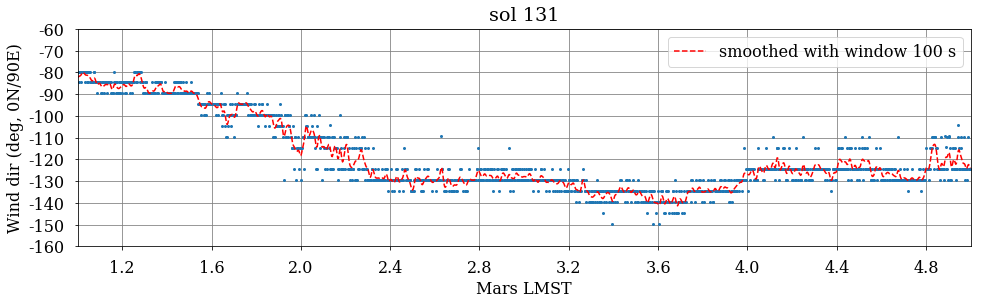

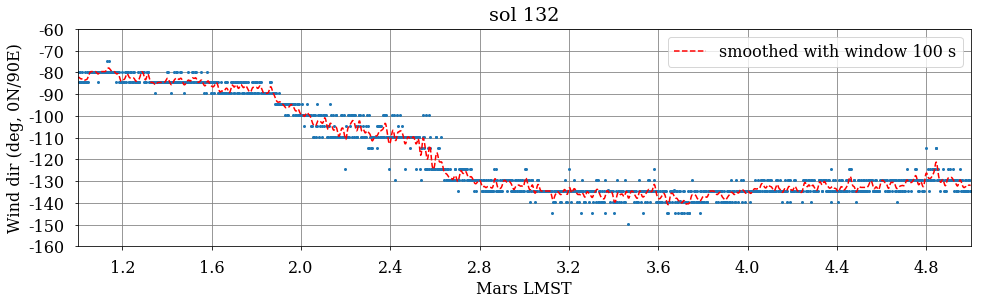

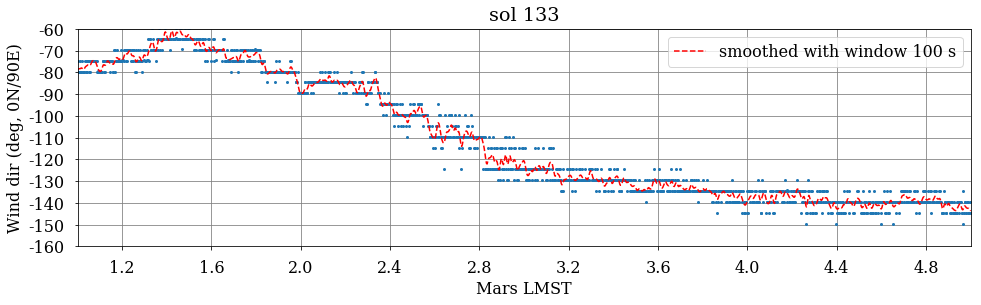

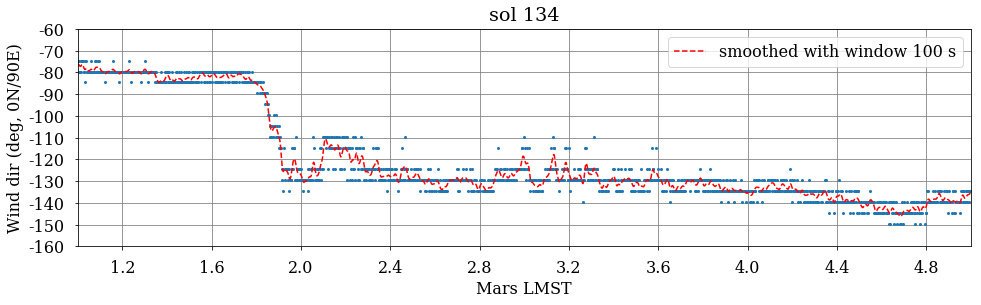

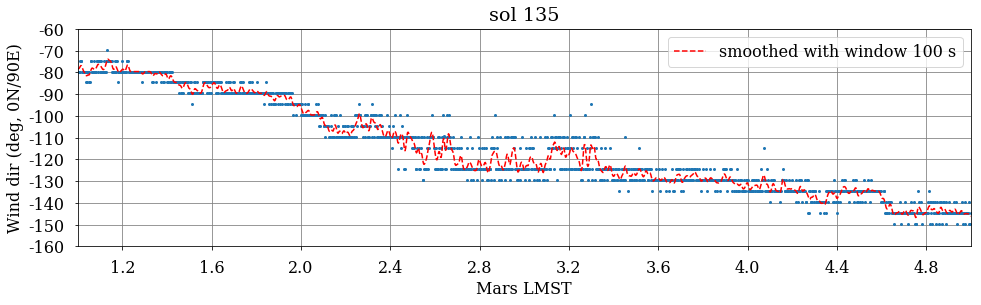

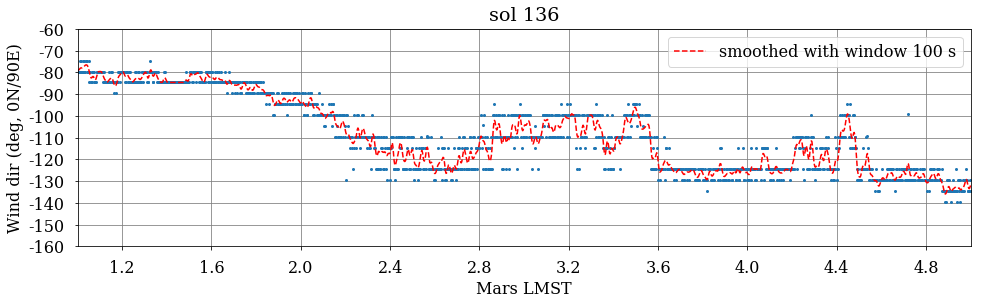

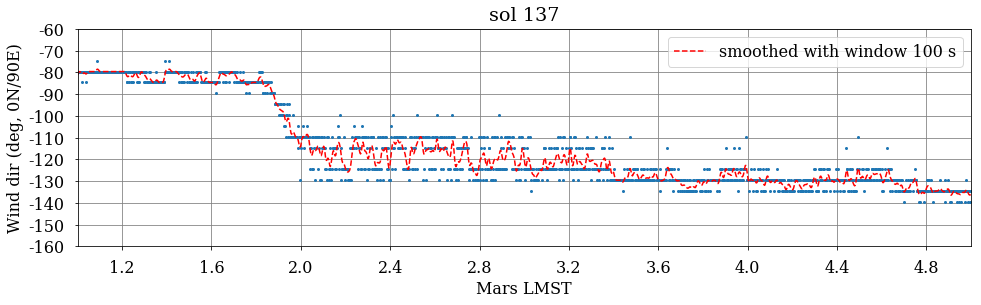

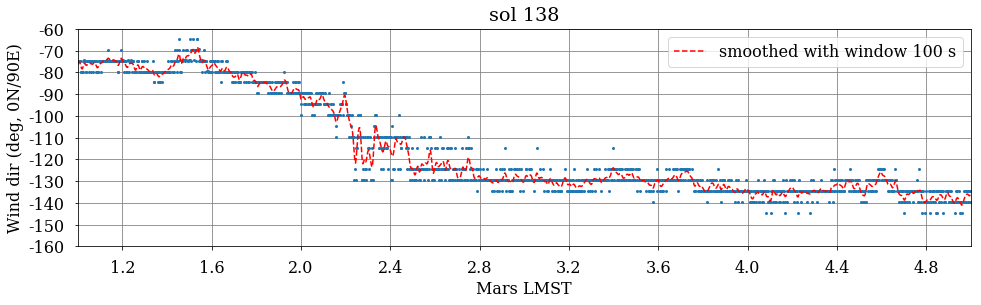

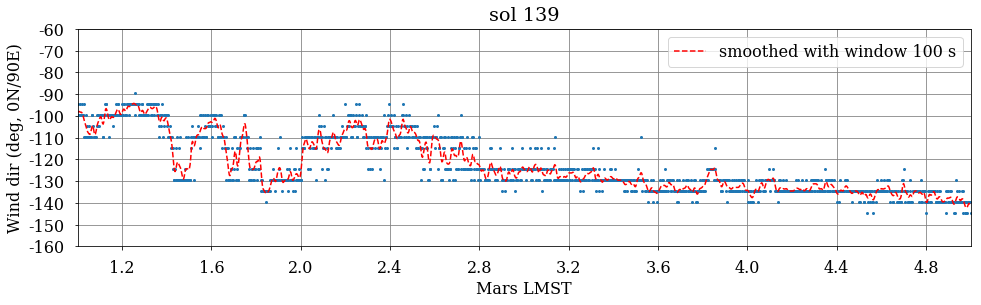

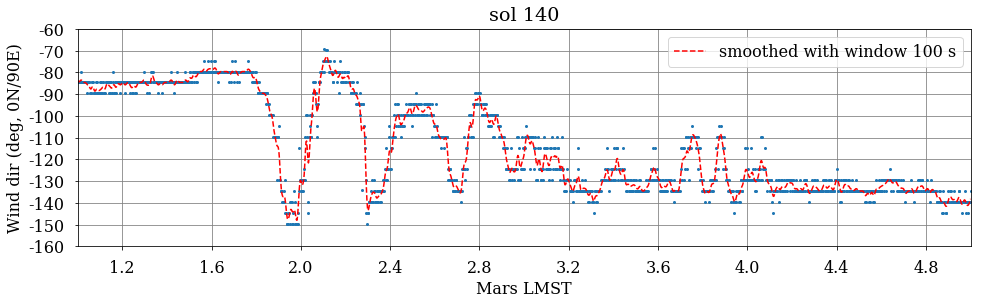

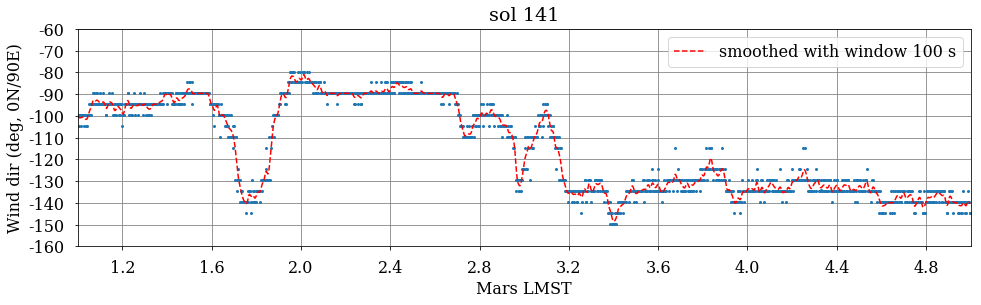

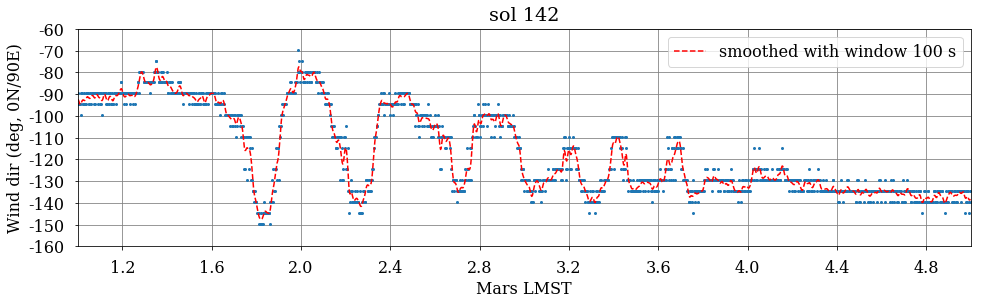

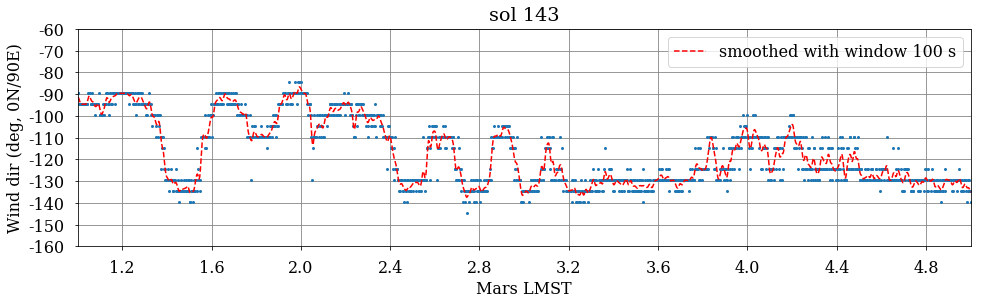

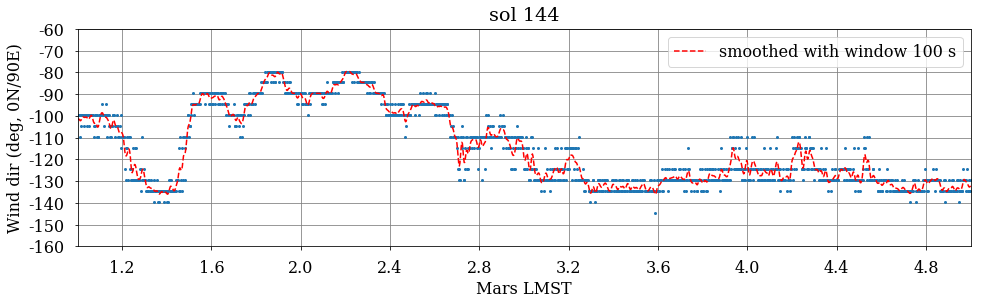

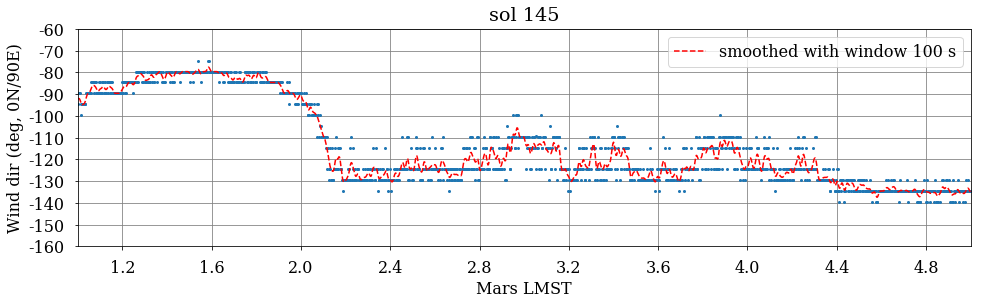

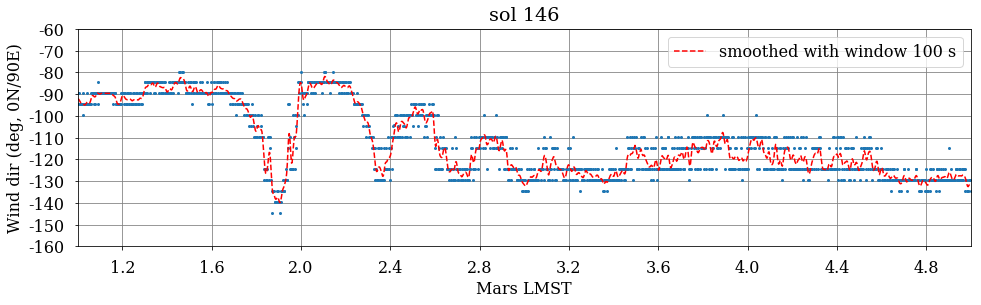

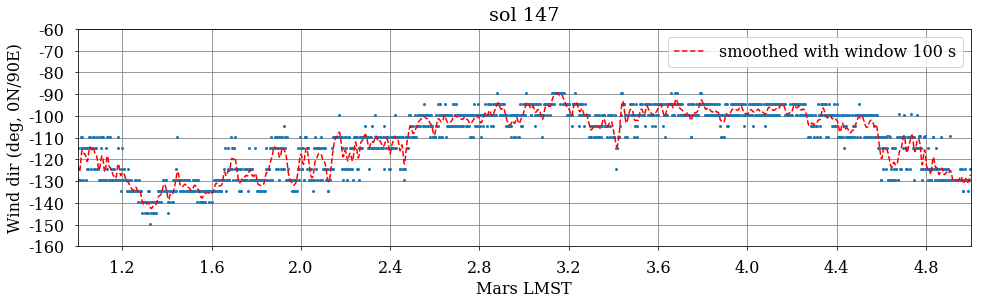

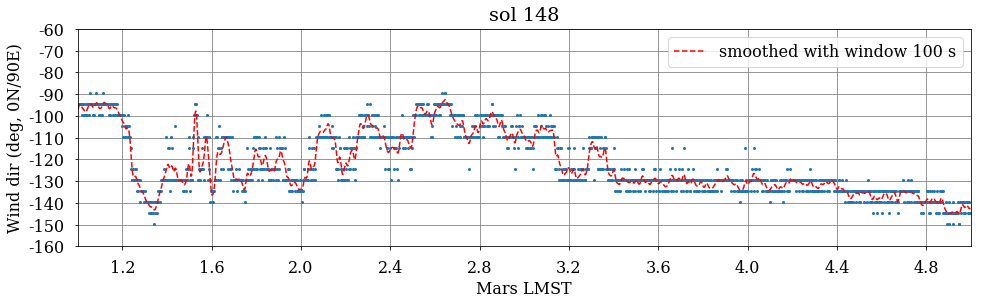

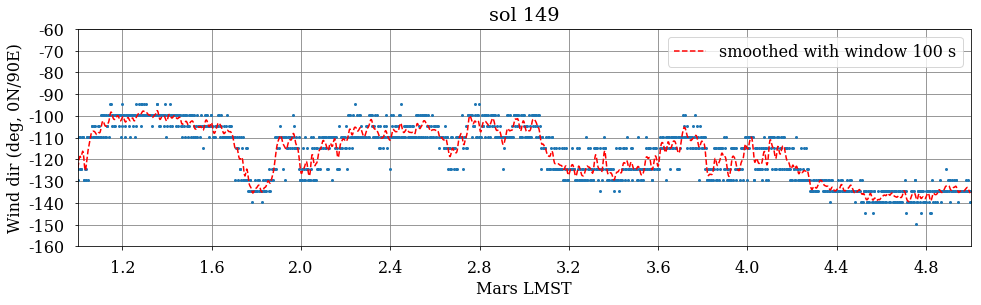

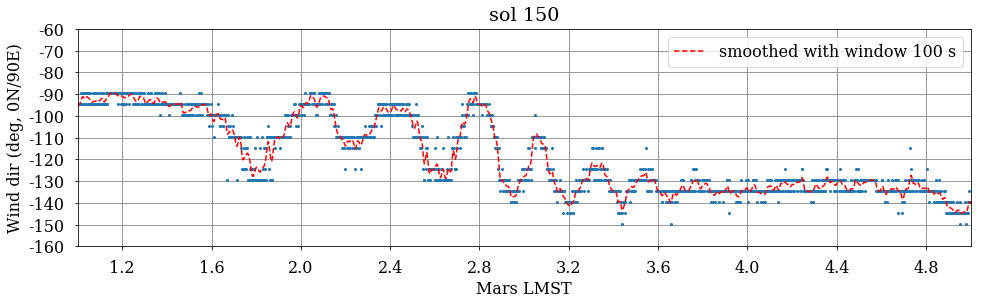

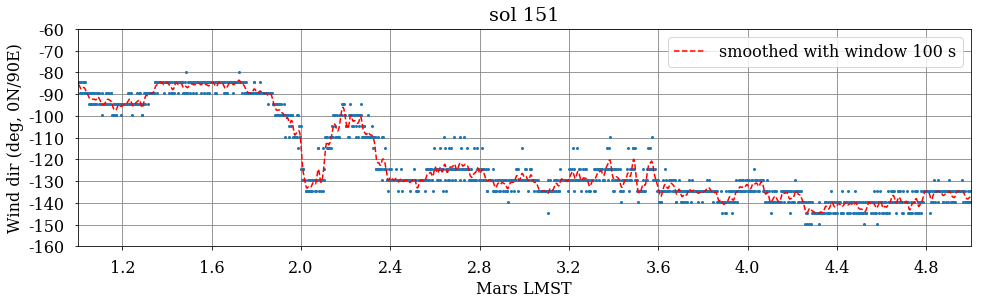

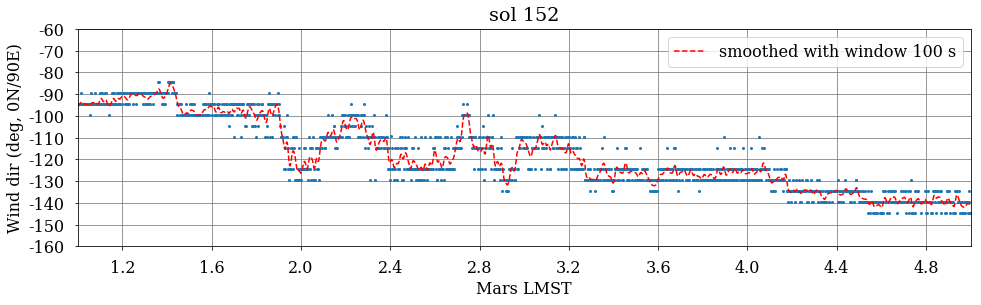

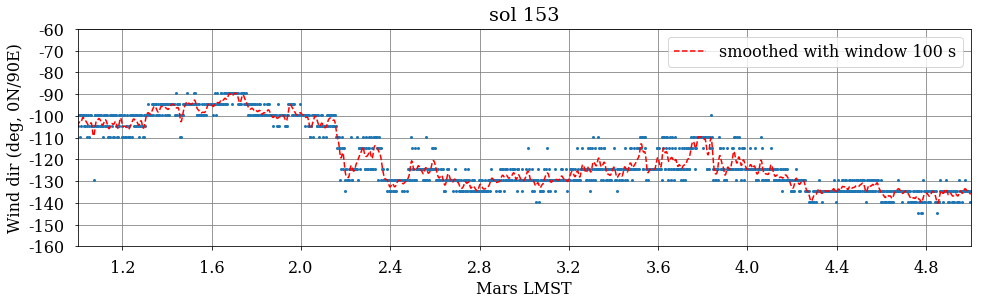

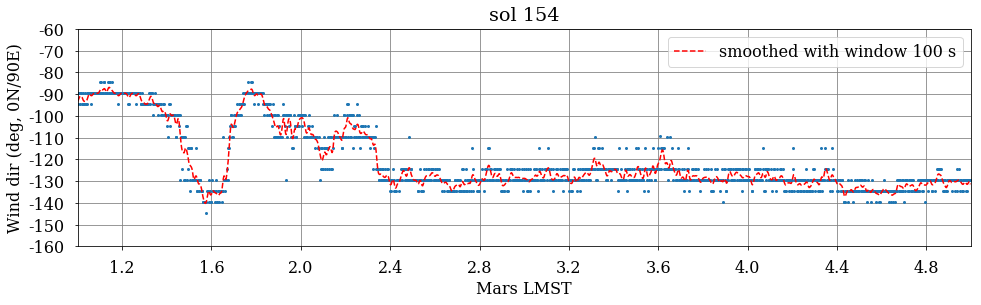

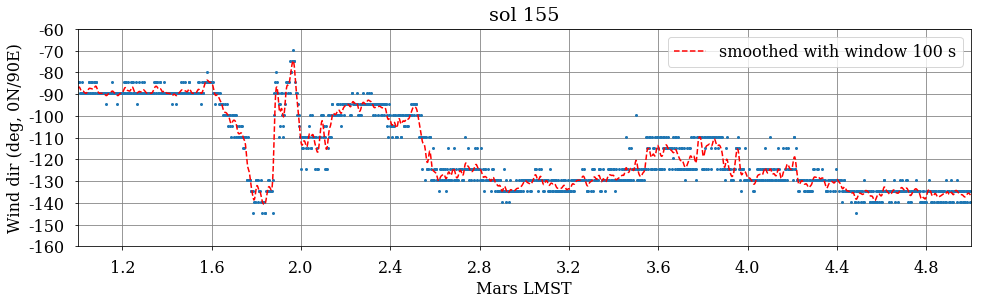

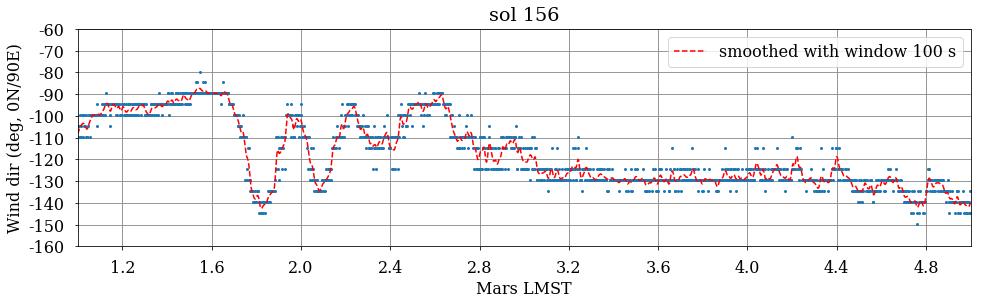

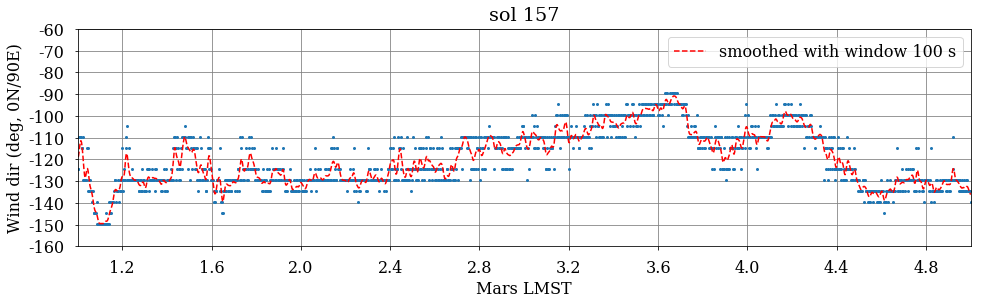

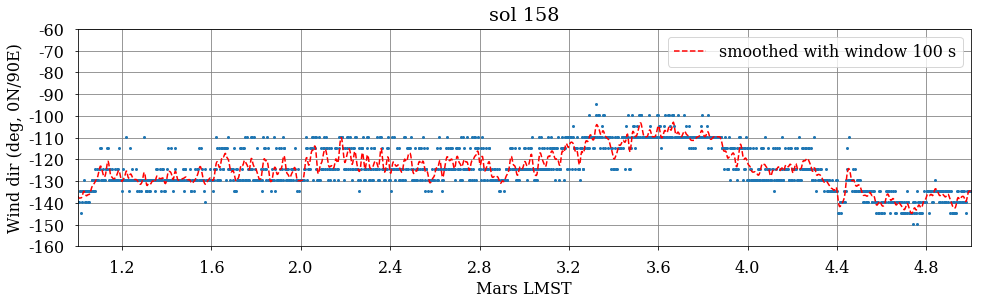

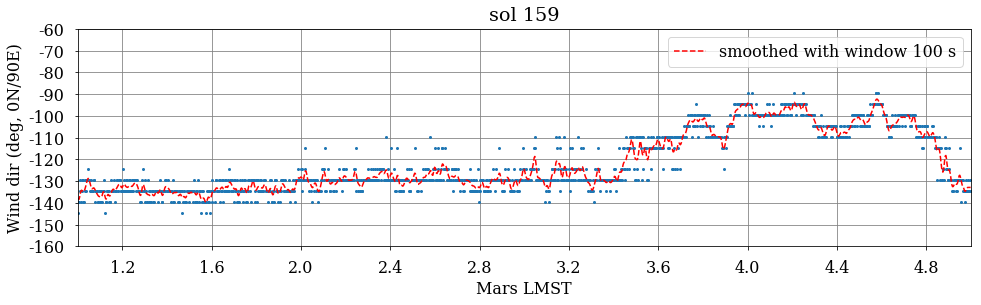

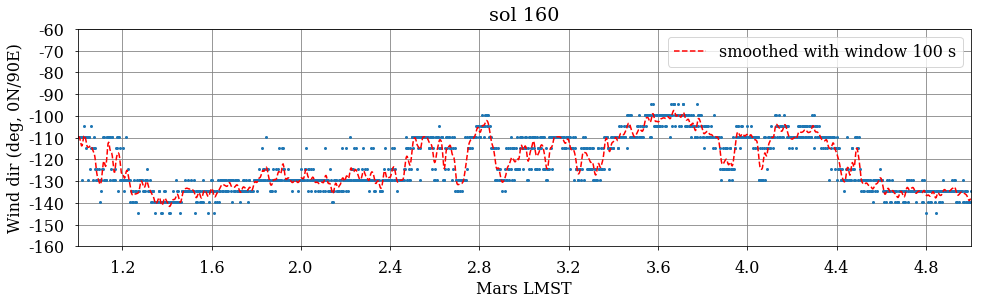

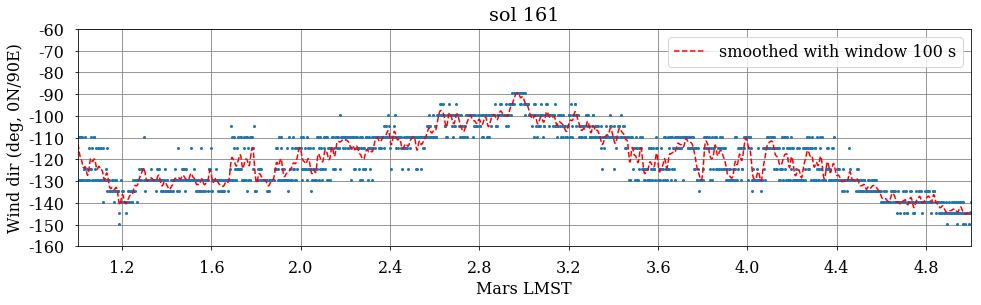

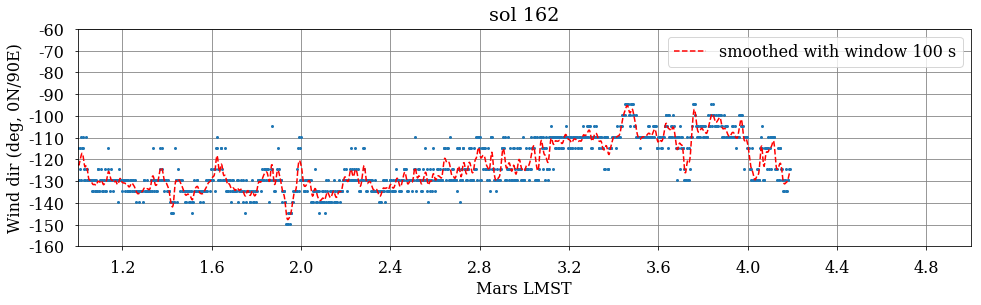

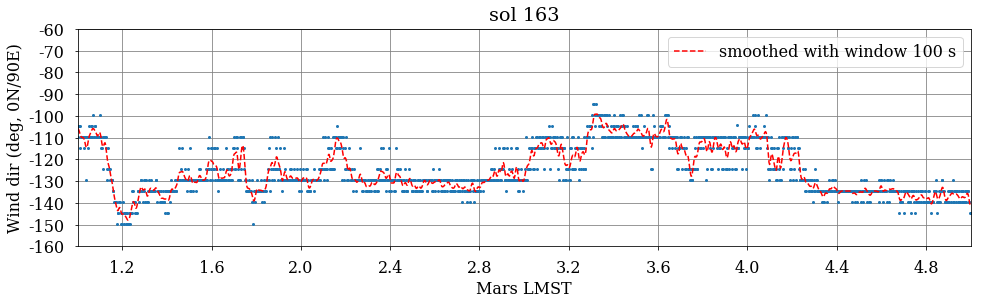

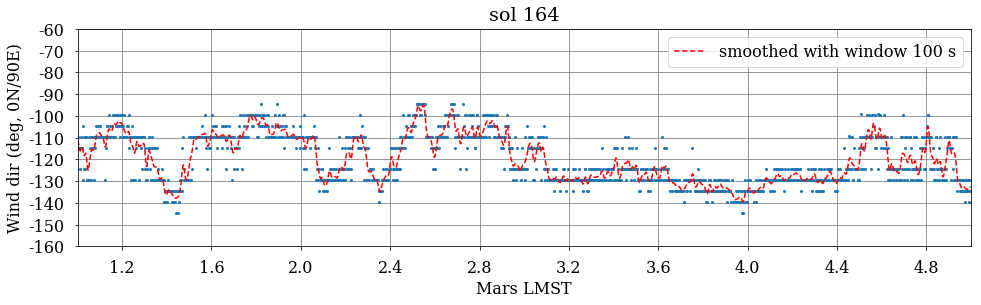

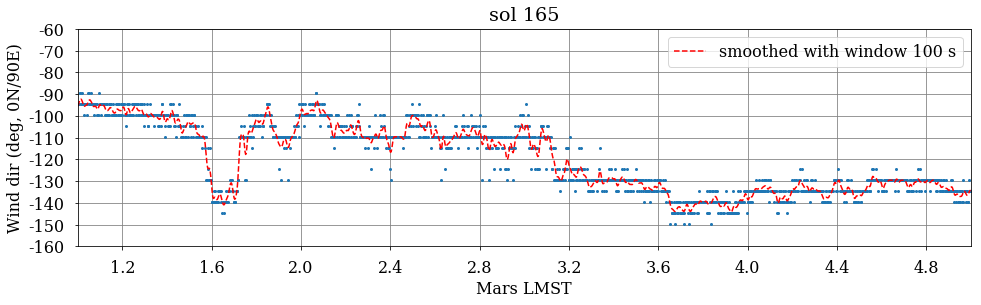

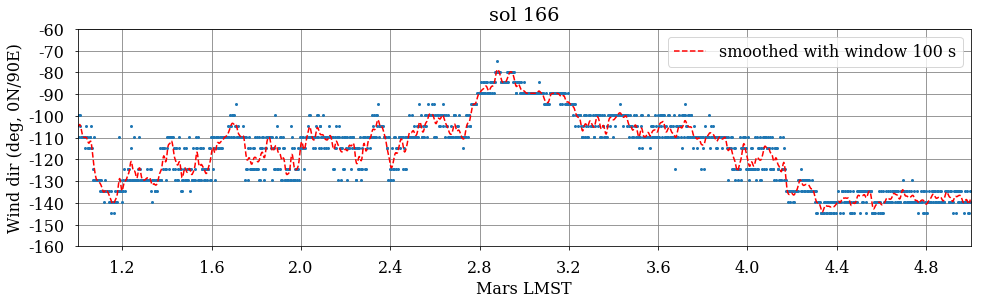

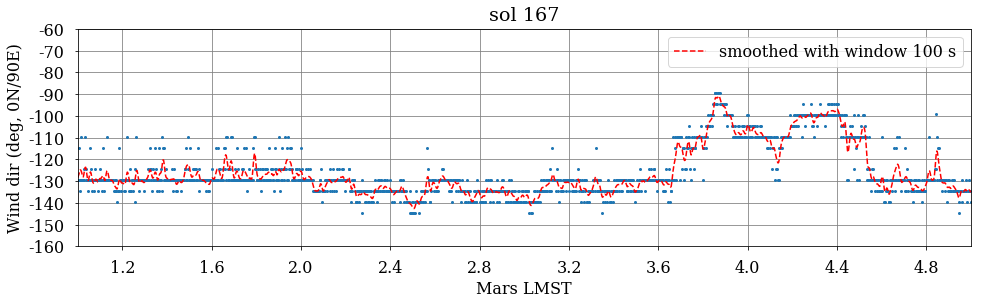

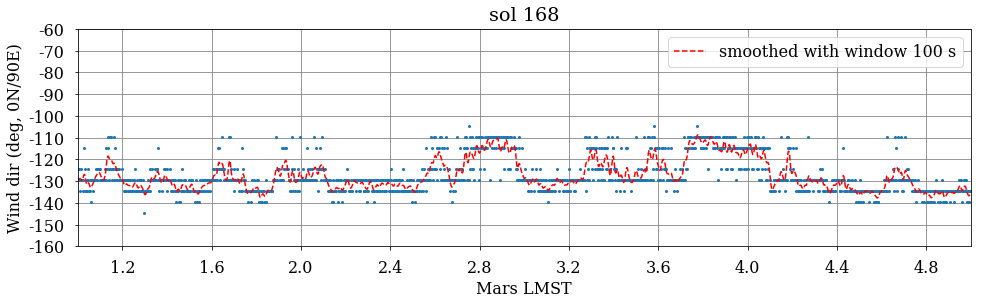

In [5]:
ymin = -160 ; ymax = -60.
for sol in np.arange(124,169):
    try:
        dataw = apss_lib.getsol(sol,var="HWS",distant=True)
        freqw = ppcompute.max(dataw["WIND_FREQUENCY"])
        apss_lib.plotvar(dataw,code=["WD"],window=win1,discrete="o",\
                                ymin = ymin, ymax = ymax,\
                                mint=mint,maxt=maxt,timetype="LMST",freq=freqw,\
                                addsmooth=True,title="sol %i"%(sol))

    except:
        pass

In [6]:
## Raphael's GW (AGU paper on compliance)
#data = apss_lib.getsol(133) #,var="HWS")
#print data["UTC"]
#apss_lib.plotvar(data,code=["PRE"],window=1000,mint=17,maxt=23,timetype="LMST",freq=2)
#apss_lib.plotvar(data,code=["WD"],window=1000,mint=17,maxt=23,timetype="LMST",freq=0.1)

In [7]:
## first plots of those events sols 138 to 144, just kept as a reference
#for sol in [138,139,140,141,142,143,144]:
#    dasol = "sol%03d" % (sol)
#    try:
#        data = apss_lib.getsol(sol)
#        apss_lib.plotvar(data,code=["PRE"],window=3000,mint=0,maxt=8,timetype="LMST",addsmooth=True,title=dasol,filename=dasol)
#        apss_lib.plotvar(data,code=["PRE"],window=3000,mint=0,maxt=8,timetype="LMST",perturbamp=0.5,filename=dasol)
#        apss_lib.plotvar(data,code=["WD","HWS"],mint=0,maxt=8,timetype="LMST",discrete=True,filename=dasol)
#    except:
#        print "PB sol "+str(sol)
#        pass

In [8]:
## attempts to find wind signatures for pressure wave packets found earlier in the mission
## ... no particular wind signatures
#for sol in [26,33,46]:
#    try:
#        data = apss_lib.getsol(sol)
#        apss_lib.plotvar(data,code=["PRE"],window=3000,mint=0,maxt=8,timetype="LTST",addsmooth=True,title="sol %i" % (sol))
#        apss_lib.plotvar(data,code=["PRE"],window=3000,mint=0,maxt=8,timetype="LTST",perturbamp=0.5)
#        apss_lib.plotvar(data,code=["WD","HWS"],mint=0,maxt=8,timetype="LTST",discrete=True)
#    except:
#        print "PB sol "+str(sol)
#        pass